In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

In [3]:
img_ori = cv2.imread('image/carIMG6.png')

In [4]:
height, width, channel = img_ori.shape

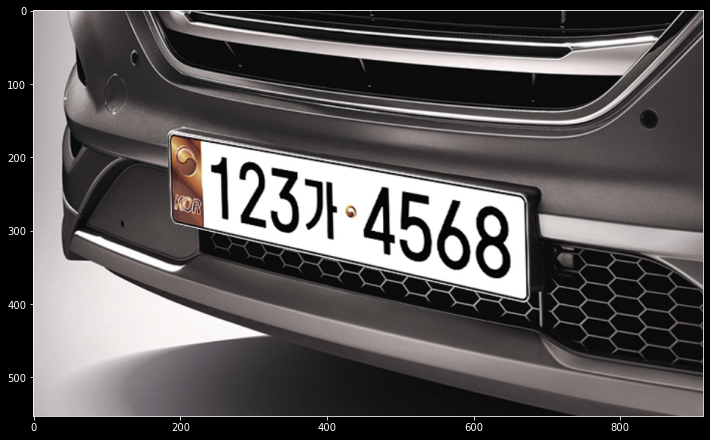

In [5]:
plt.figure(figsize=(12,10))
plt.imshow(img_ori, cmap = 'gray')

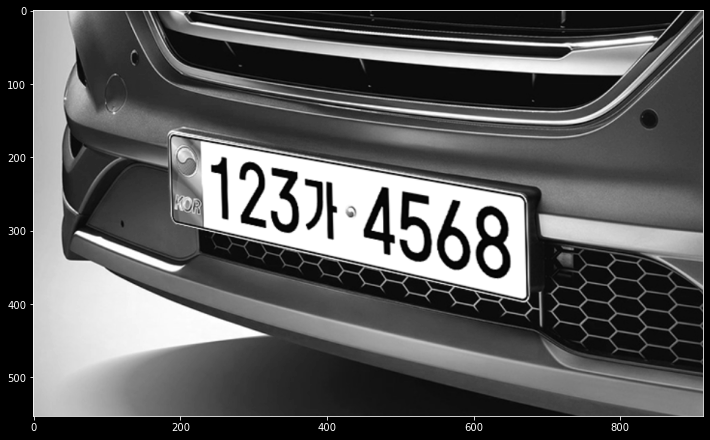

In [6]:
# Convert Image to GrayScale

hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# hsv의 v채널만 사용 -> 거의 유사
gray = hsv[:, :, 2]

# gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

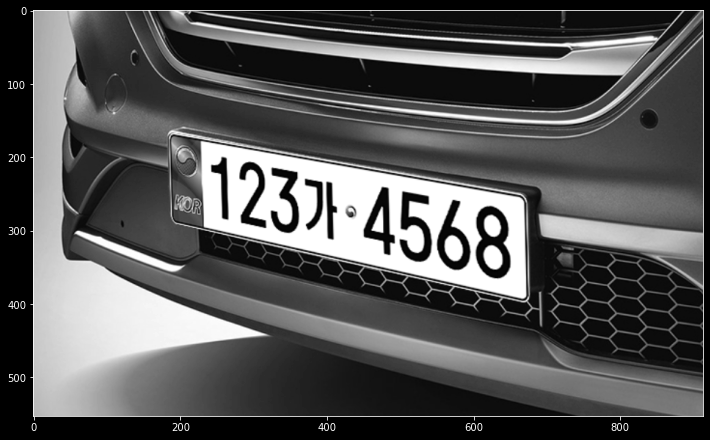

In [7]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

## Maximize Constant(Optional) (상수 최대화, 최적화?)

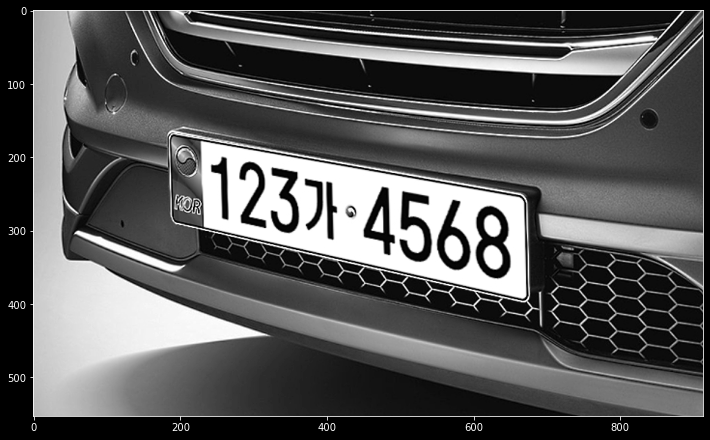

In [8]:
# cv2.getStrcturingElement(): 구조요소를 생성
# cv2.getStructuringElement(커널의 형태, 커널의 크기, 중심점)로 구조 요소을 생성
# cv2.MORPH_RECT: 직사각형, cv2.MORPH_CROSS: 십자가형, cv2.MORPH_ELLIPSE: 타원형
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# 모폴로지 변환은 주로 영상 내 픽셀값 대체에 사용
# 이를 응용해서 노이즈 제거, 요소 결합 및 분리, 강도 피크 검출 등에 이용
# 집합의 포함 관계, 이동(translation), 대칭(reflection), 여집합(complement), 차집합(difference) 등의 성질을 사용
# 모폴로지 변환 ex) 팽창(dilation), 침식(erosion)
# cv2.MORPH_TOPHAT: 원본 이미지와 opening한 이미지의 차이
imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap = 'gray')

## Adaptive Thresholding

- GaussianBlur(): 이미지를 흐릿하게 하여 미세한 노이즈를 줄이기 위해
- adaptiveThreshold(): 이미지에 Threshold를 지정해 임계치보다 낮은 값은 0으로, 임계치보다 높으면 255.0으로 해서 이미지를 구별하기 쉽게 -> 검은색과 흰색으로 이미지를 나눌 수 있음(번호판이 잘 보이도록)

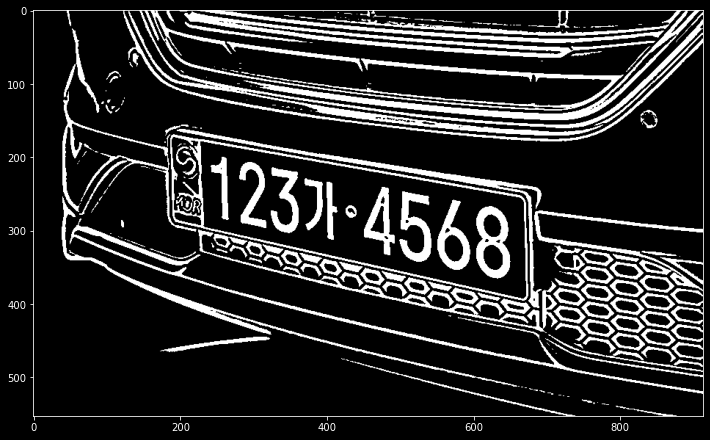

In [9]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue = 255.0,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize = 19,
    C=9
)

plt.figure(figsize=(12,10))
plt.imshow(img_thresh, cmap='gray')

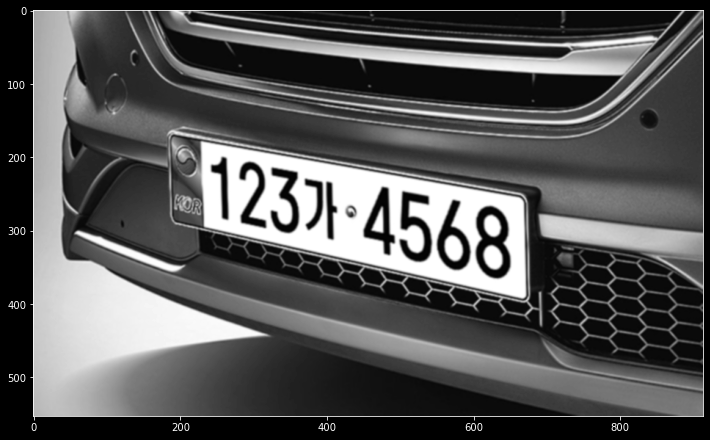

In [10]:
plt.figure(figsize=(12,10))
plt.imshow(img_blurred, cmap='gray')

##  Find Contours - 이미지에서 윤곽선 찾기

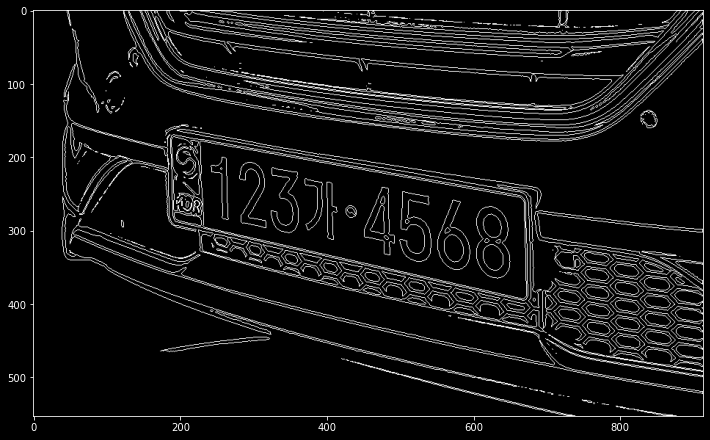

In [11]:
# 윤곽선 찾기
contours, _= cv2.findContours(
    img_thresh,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)

# 윤곽선 그리기
# contourIdx = -1 : 전체 contour를 그림
cv2.drawContours(temp_result, contours = contours, contourIdx = -1, color=(255,255,255))

plt.figure(figsize=(12,10))
plt.imshow(temp_result)

In [12]:
# _, contours, _ = cv2.findContours(
#     img_thresh, 
#     mode=cv2.RETR_LIST, 
#     method=cv2.CHAIN_APPROX_SIMPLE
# )

# _, contours, _ 에서
# _, contours, hierarchy 
# contours, hierarchy

In [13]:
contours

[array([[[794, 539]],
 
        [[795, 540]],
 
        [[799, 540]],
 
        [[800, 541]],
 
        [[803, 541]],
 
        [[804, 542]],
 
        [[806, 542]],
 
        [[807, 541]],
 
        [[808, 542]],
 
        [[809, 542]],
 
        [[810, 543]],
 
        [[818, 543]],
 
        [[819, 544]],
 
        [[822, 544]],
 
        [[824, 546]],
 
        [[825, 545]],
 
        [[827, 545]],
 
        [[828, 546]],
 
        [[832, 546]],
 
        [[833, 547]],
 
        [[836, 547]],
 
        [[837, 548]],
 
        [[843, 548]],
 
        [[844, 549]],
 
        [[846, 549]],
 
        [[847, 550]],
 
        [[848, 549]],
 
        [[849, 550]],
 
        [[851, 550]],
 
        [[852, 551]],
 
        [[857, 551]],
 
        [[858, 552]],
 
        [[876, 552]],
 
        [[872, 552]],
 
        [[871, 551]],
 
        [[863, 551]],
 
        [[862, 550]],
 
        [[856, 550]],
 
        [[855, 549]],
 
        [[849, 549]],
 
        [[848, 548]],
 
        [[844, 5

## Prepare Data

- 번호판의 위치를 찾기 쉽도록 조정

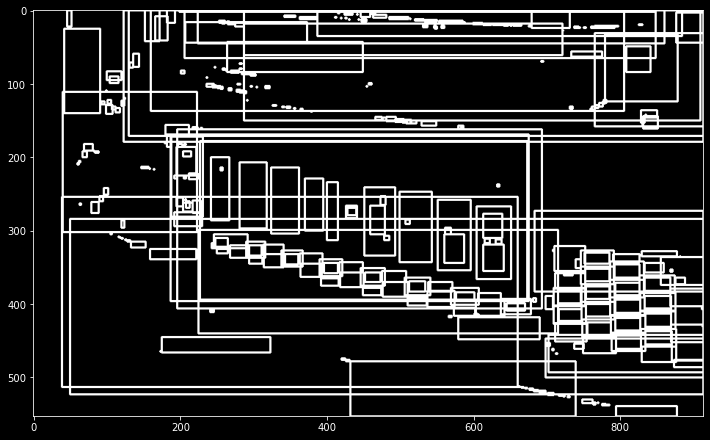

In [14]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) 
    # cv2.boundingRect(): 윤곽선을 감싸는 사각형을 구함
    cv2.rectangle(temp_result, pt1 = (x, y), pt2 = (x+w, y+h), color=(255,255,255), thickness = 2)
    # cv2.rectangle(): 이미지에 사각형을 그림
    
    # insert to dict
    contours_dict.append({
        'contour' : contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w/2),  # contour의 중심 좌표 x
        'cy': y + (h/2)   # contour의 중심 좌표 y
    })
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [15]:
contours_dict

[{'contour': array([[[794, 539]],
  
         [[795, 540]],
  
         [[799, 540]],
  
         [[800, 541]],
  
         [[803, 541]],
  
         [[804, 542]],
  
         [[806, 542]],
  
         [[807, 541]],
  
         [[808, 542]],
  
         [[809, 542]],
  
         [[810, 543]],
  
         [[818, 543]],
  
         [[819, 544]],
  
         [[822, 544]],
  
         [[824, 546]],
  
         [[825, 545]],
  
         [[827, 545]],
  
         [[828, 546]],
  
         [[832, 546]],
  
         [[833, 547]],
  
         [[836, 547]],
  
         [[837, 548]],
  
         [[843, 548]],
  
         [[844, 549]],
  
         [[846, 549]],
  
         [[847, 550]],
  
         [[848, 549]],
  
         [[849, 550]],
  
         [[851, 550]],
  
         [[852, 551]],
  
         [[857, 551]],
  
         [[858, 552]],
  
         [[876, 552]],
  
         [[872, 552]],
  
         [[871, 551]],
  
         [[863, 551]],
  
         [[862, 550]],
  
         [[856, 550]],
  
 

In [16]:
for d in contours_dict:
    print(d)

{'contour': array([[[794, 539]],

       [[795, 540]],

       [[799, 540]],

       [[800, 541]],

       [[803, 541]],

       [[804, 542]],

       [[806, 542]],

       [[807, 541]],

       [[808, 542]],

       [[809, 542]],

       [[810, 543]],

       [[818, 543]],

       [[819, 544]],

       [[822, 544]],

       [[824, 546]],

       [[825, 545]],

       [[827, 545]],

       [[828, 546]],

       [[832, 546]],

       [[833, 547]],

       [[836, 547]],

       [[837, 548]],

       [[843, 548]],

       [[844, 549]],

       [[846, 549]],

       [[847, 550]],

       [[848, 549]],

       [[849, 550]],

       [[851, 550]],

       [[852, 551]],

       [[857, 551]],

       [[858, 552]],

       [[876, 552]],

       [[872, 552]],

       [[871, 551]],

       [[863, 551]],

       [[862, 550]],

       [[856, 550]],

       [[855, 549]],

       [[849, 549]],

       [[848, 548]],

       [[844, 548]],

       [[843, 547]],

       [[837, 547]],

       [[836, 546]],

## Select Candidates by Char Size

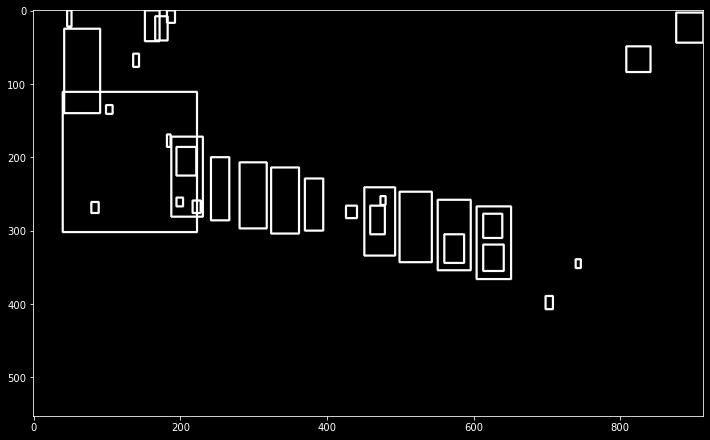

In [17]:
MIN_AREA = 80   # boundingRect의 최소 넓이
MIN_WIDTH, MIN_HEIGHT = 2, 8   # boundingRect의 최소 너비와 높이
MIN_RATIO, MAX_RATIO = 0.25, 1.0   # # boundingRect의 가로 대비 세로 비율 최소, 최대

possible_contours = []   # 가능한 영역을 저장 

cnt = 0

for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
#       print(d['idx'])
        possible_contours.append(d)  
        # 각 윤곽선의 idx 값을 매겨놓고, 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼낼 것
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#   cv2.drawContours(temp_result, d['contour'], -1, (255,255,255))
    cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2 = (d['x'] + d['w'], d['y']+d['h']), color=(255,255,255), thickness = 2)
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap = 'gray')

## Select Candidates by Arrangement of Contours

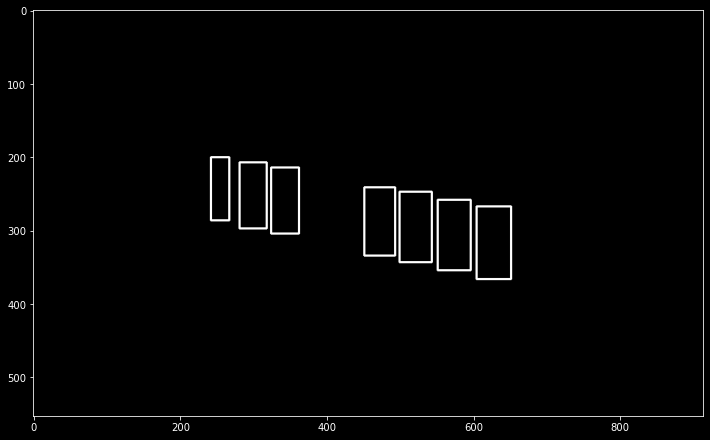

In [18]:
MAX_DIAG_MULTIPLAYER = 5   # countour와 contour 사이의 거리
MAX_ANGLE_DIFF = 12.0   #
MAX_AREA_DIFF = 0.5   #
MAX_WIDTH_DIFF = 0.8   #
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3.  #

# Recursive(재귀적) 방식으로 번호판 후보군 찾을 예정
def find_chars(contour_list):
    matched_result_idx = []   # 최종적으로 남는 결과물의 인덱스 값을 저장
    
    for d1 in contour_list:
        matched_contours_idx = []
        
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:   # 같은 contour이므로 비교할 필요 없음
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            # np.linalg.norm(a-b): 벡터 a와 b 사이의 거리를 구함.
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['x'] - d2['y']]))
                
            if dx == 0:
                angle_diff = 90
                
            else:
                # np.arctan(): 아크탄젠트 값을 구함(라디안)
                # np.degrees(): 라디안을 '도'로 변경
                angle_diff = np.degrees(np.arctan(dy/dx))  
                
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            # 기준에 맞는 contour의 인덱스만 matched_contours_idx 리스트에 넣기
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLAYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        # append this contour
        matched_contours_idx.append(d1['idx'])
            
        # 번호판 후보군의 윤곽선 개수가 3보다 작으면 번호판일 확률이 낮으므로 후보군에서 제거
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
                
        # 위의 if len() ~ 까지 통과할 경우 최종 후보군에 추가
        matched_result_idx.append(matched_contours_idx)
            
        # 최종 후보군에 들지 않은 contour끼리 한 번 더 비교
        unmatched_contour_idx = []
        for d4 in contour_list:
            # matched_contours_idx 리스트에 있지 않은 contour들을 골라 
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
                    
        # np.take(a, idx): a에서 idx와 같은 인덱스 값만 추출 
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
                
        # recursive : 다시 find_chars()에 넣어 살아남은 contour를 최종 후보군 list에 넣기
        recursive_contour_list = find_chars(unmatched_contour)
            
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
                
        break
            
    return matched_result_idx
    
result_idx = find_chars(possible_contours)

# find_chars에서 결과로 나온 result_idx를 모은 다음, 남은 contour들을 그리기 

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
# visusalize possible contours
temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for r in matched_result:
    for d in r:
        # cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2 = (d['x'] + d['w'], d['y'] + d['h']), color = (255,255,255), thickness = 2)
        
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

## Rotate Plate Images

In [19]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    # x 방향에 순차적으로 정렬
    sorted_chars = sorted(matched_chars, key = lambda x: x['cx'])
    
    # plate라고 생각되는 것들의 center x, y 좌표 구하기
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x'] * PLATE_WIDTH_PADDING)
    
    sum_height = 0
    
    for d in sorted_chars:
        sum_height += d['h']
        
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    # cv2.getRotationMatrix2D() : RotationMatrix 구하기
    rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy), angle = angle, scale = 1.0)
    
    # cv2.warpAffine() : 이미지 변형(삐뚤어진 이미지 돌리기)
    img_rotated = cv2.warpAffine(img_thresh, M = rotation_matrix, dsize = (width, height))
    
    # cv2.getRectSubPix() : 회전된 이미지에서 원하는 부분만 잘라내기
    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize = (int(plate_width), int(plate_height)),
        center = (int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO \
    or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
        
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x' : int(plate_cx - plate_width / 2),
        'y' : int(plate_cy - plate_height / 2),
        'w' : int(plate_width),
        'h' : int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    
    plt.imshow(img_cropped, cmap = 'gray')

In [20]:
img_blurred

array([[162, 163, 164, ..., 134, 133, 126],
       [162, 163, 164, ..., 137, 127, 117],
       [162, 163, 164, ..., 135, 112,  99],
       ...,
       [181, 182, 182, ..., 123, 124, 125],
       [181, 181, 182, ..., 122, 123, 124],
       [180, 181, 182, ..., 122, 123, 123]], dtype=uint8)

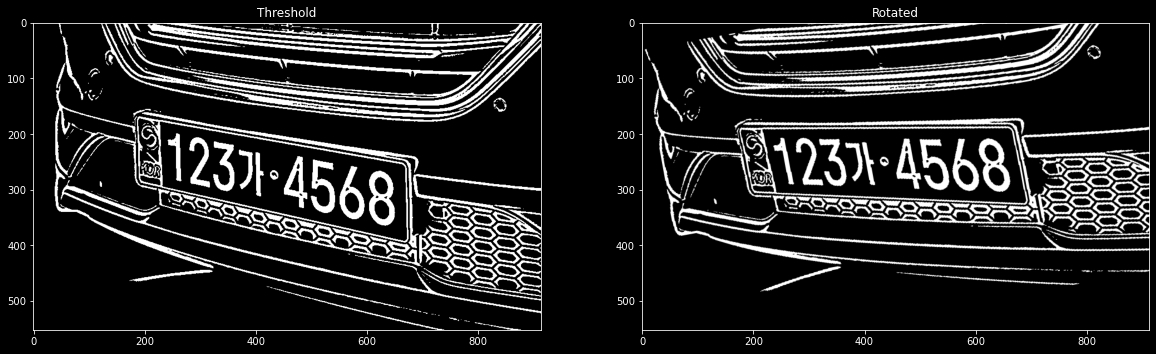

In [21]:
rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy), angle = angle, scale = 1.0)

img_rotated = cv2.warpAffine(img_thresh, M = rotation_matrix, dsize = (width, height))

plt.figure(figsize = (20,20))
plt.subplot(1, 2, 1)
plt.title('Threshold')
plt.imshow(img_thresh, cmap = 'gray') # img_blurred, temp_result


plt.subplot(1, 2, 2)
plt.title('Rotated')
plt.imshow(img_rotated, cmap = 'gray')

In [22]:
print(len(matched_chars))

matched_chars[0]

3


{'contour': array([[[292, 207]],
 
        [[291, 208]],
 
        [[289, 208]],
 
        [[287, 210]],
 
        [[286, 210]],
 
        [[286, 211]],
 
        [[284, 213]],
 
        [[284, 214]],
 
        [[283, 215]],
 
        [[283, 218]],
 
        [[282, 219]],
 
        [[282, 224]],
 
        [[281, 225]],
 
        [[281, 229]],
 
        [[282, 230]],
 
        [[285, 230]],
 
        [[286, 231]],
 
        [[289, 231]],
 
        [[289, 222]],
 
        [[290, 221]],
 
        [[290, 220]],
 
        [[293, 217]],
 
        [[294, 217]],
 
        [[295, 216]],
 
        [[298, 216]],
 
        [[299, 217]],
 
        [[300, 217]],
 
        [[301, 218]],
 
        [[302, 218]],
 
        [[304, 220]],
 
        [[304, 221]],
 
        [[306, 223]],
 
        [[306, 224]],
 
        [[307, 225]],
 
        [[307, 227]],
 
        [[308, 228]],
 
        [[308, 237]],
 
        [[307, 238]],
 
        [[307, 240]],
 
        [[305, 242]],
 
        [[305, 243]],
 
     

In [23]:
matched_chars[0]['cx']

299.5

In [24]:
len(matched_result)

2

In [25]:
sorted_chars[-1]

{'contour': array([[[326, 214]],
 
        [[325, 215]],
 
        [[325, 223]],
 
        [[326, 224]],
 
        [[326, 225]],
 
        [[332, 225]],
 
        [[333, 226]],
 
        [[338, 226]],
 
        [[339, 227]],
 
        [[346, 227]],
 
        [[347, 228]],
 
        [[348, 228]],
 
        [[349, 229]],
 
        [[349, 231]],
 
        [[344, 236]],
 
        [[344, 237]],
 
        [[343, 238]],
 
        [[343, 239]],
 
        [[341, 241]],
 
        [[341, 242]],
 
        [[340, 243]],
 
        [[340, 244]],
 
        [[338, 246]],
 
        [[338, 247]],
 
        [[336, 249]],
 
        [[336, 250]],
 
        [[335, 251]],
 
        [[335, 252]],
 
        [[336, 253]],
 
        [[336, 255]],
 
        [[337, 256]],
 
        [[342, 256]],
 
        [[343, 257]],
 
        [[344, 257]],
 
        [[345, 258]],
 
        [[346, 258]],
 
        [[351, 263]],
 
        [[351, 264]],
 
        [[352, 265]],
 
        [[352, 267]],
 
        [[353, 268]],
 
     

## Another Thresholding to Find Chars

In [28]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize = (0, 0), fx = 1.6, fy = 1.6)
    _, plate_img = cv2.threshold(plate_img, thresh = 0.0, maxval = 255.0, type = cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again(same as above)
    _, contours = cv2.findContours(plate_img, mode = cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)   # pointSetBoundingRect
#         x, y, w, h = cv2.pointSetBoundingRect(contour)
        
        area = w * h
        ratio = w/ h
        
        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO :
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    # 이미지를 번호판 부분만 Crop
    img_result = plate_img[plate_min_y : plate_max_y, plate_min_x : plate_max_x]
    
    # 글씨를 읽기 전 더 잘 읽기 위해 가우시안 블러 -> Threshold
    img_result = cv2.GaussianBlur(img_result, ksize = (3,3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh = 0.0, maxval = 255.0, type = cv2.THRESH_BINARY | cv2.THRESH_ORSU)
    
    # cv2.copyMakeBorder() : 이미지에 패딩(검은색으로 약간의 여백)을 준다. -> pytesseract가 잘 읽게 하기 위해
    img_result = cv2.copyMakeBorder(img_result, top = 10, bottom = 10, left = 10, right = 10,
                                   borderType = cv2.BORDER_CONSTANT, value = (0, 0, 0))
    
    # 이미지에서 String 뽑아내기, 언어 : Korean
    # config에서, psm 7 : 이미지 안에 글자가 한 줄로 놓여있다는 가정
    # config에서, oem 0 : 테서랙트 레거시 엔진 0 (초기) 사용
    chars = pytesseract.image_to_string(img_result, lang = 'kor', config = '--psm 7 --oem 0')
    
    result_chars = ""
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
                
            result_chars += c
            
    print(result_chars)
    plate_chars.append(result_chars)
    
    # 구한 문자열 중 가장 긴 것이 우리가 찾는 번호판
    if has_digit and len(result_chars) > longest_text:
        longest_idx = i
        
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap = 'gray')

In [26]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    _, contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

In [29]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), 
              pt2=(info['x']+info['w'], info['y']+info['h']),
              color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)

IndexError: list index out of range

In [187]:
longest_idx

-1